In [42]:
import numpy as np
import pandas as pd
import json
import os
from parse import parse
import pprint
pp = pprint.PrettyPrinter(indent=2)
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

In [73]:
# Find out all pets that have an image

# Train dataset
train_df = pd.read_csv('data/train/train.csv')
train_pet_ids = train_df['PetID'].tolist()
train_pet_ids = set(train_pet_ids)

train_imgs_path = 'data/train_images'
train_imgs_filenames = os.listdir(train_imgs_path)
train_imgs_filepaths = [os.path.join(train_imgs_path, fname) for fname in train_imgs_filenames]
img_filename_format = '{}-{}.jpg'
train_img_ids = [parse(img_filename_format, img_f)[0] for img_f in train_imgs_filenames]
# Pets can have several images
train_img_ids = set(train_img_ids)
train_ids_no_img = train_pet_ids - train_img_ids

len(train_pet_ids), len(train_img_ids), len(train_ids_no_img)

(14993, 14652, 341)

In [74]:
# Test dataset
test_df = pd.read_csv('data/test/test.csv')
test_pet_ids = test_df['PetID'].tolist()
test_pet_ids = set(test_pet_ids)

test_imgs_path = 'data/test_images'
test_imgs_filenames = os.listdir(test_imgs_path)
test_imgs_filepaths = [os.path.join(test_imgs_path, fname) for fname in test_imgs_filenames]
test_img_ids = [parse(img_filename_format, img_f)[0] for img_f in test_imgs_filenames]

test_img_ids = set(test_img_ids)
test_ids_no_img = test_pet_ids - test_img_ids

len(test_pet_ids), len(test_img_ids), len(test_ids_no_img)

(3948, 3821, 127)

In [96]:
# Overview of image metadata
train_metadata_path = 'data/train_metadata'
train_metadata_filenames = os.listdir(train_metadata_path)
train_metadata_filepaths = [os.path.join(train_metadata_path, fname) for fname in train_metadata_filenames]

metadata_keys = set()
metadata_list = []
for fpath in train_metadata_filepaths:
    with open(fpath, 'rb') as file:
        metadata = json.load(file)
        metadata_list.append(metadata)
        metadata_keys.update(metadata.keys())
metadata_keys

{'cropHintsAnnotation',
 'faceAnnotations',
 'imagePropertiesAnnotation',
 'labelAnnotations',
 'textAnnotations'}

In [97]:
len(metadata_list), len(train_imgs_filenames)

(58311, 58311)

In [99]:
# Example of metadata values
for key in metadata_keys:
    for metadata in metadata_list:
        if key in metadata:
            break
    print('****** %s ******' % key)
    pp.pprint(metadata[key])

****** textAnnotations ******
[ { 'boundingPoly': { 'vertices': [ {'x': 38, 'y': 208},
                                    {'x': 118, 'y': 208},
                                    {'x': 118, 'y': 219},
                                    {'x': 38, 'y': 219}]},
    'description': 'cr\nin fuel pricing\n',
    'locale': 'en'}]
****** labelAnnotations ******
[ { 'description': 'cat',
    'mid': '/m/01yrx',
    'score': 0.9943703,
    'topicality': 0.9943703},
  { 'description': 'small to medium sized cats',
    'mid': '/m/07k6w8',
    'score': 0.9213904,
    'topicality': 0.9213904},
  { 'description': 'whiskers',
    'mid': '/m/01l7qd',
    'score': 0.91749674,
    'topicality': 0.91749674},
  { 'description': 'cat like mammal',
    'mid': '/m/0307l',
    'score': 0.89707345,
    'topicality': 0.89707345},
  { 'description': 'eye',
    'mid': '/m/014sv8',
    'score': 0.80012083,
    'topicality': 0.80012083},
  { 'description': 'khao manee',
    'mid': '/m/07kdjg0',
    'score': 0.79784

In [100]:
# Count how many images have different metadata types
metadata_keys_lens = {}
for key in metadata_keys:
    metadata_keys_lens[key] = 0
for metadata in metadata_list:
    for key in metadata_keys:
        if key in metadata:
            metadata_keys_lens[key] += 1


In [101]:
metadata_keys_lens

{'cropHintsAnnotation': 58311,
 'faceAnnotations': 656,
 'imagePropertiesAnnotation': 58311,
 'labelAnnotations': 58299,
 'textAnnotations': 3356}

In [102]:
# Check for "topicality" field, if its equal everywhere to score, then no AssertionError will raise
for metadata in metadata_list:
    if 'labelAnnotations' in metadata:
        assert np.product([la['score'] == la['topicality'] for la in metadata['labelAnnotations']]) == 1

In [103]:
test_metadata_path = 'data/test_metadata'
test_metadata_filenames = os.listdir(test_metadata_path)
test_metadata_filepaths = [os.path.join(test_metadata_path, fname) for fname in test_metadata_filenames]

test_metadata_keys = set()
test_error_files = []
test_metadata_list = []
for fpath in test_metadata_filepaths:
    with open(fpath, 'rb') as file:
        metadata = json.load(file)
        test_metadata_list.append(metadata)
        test_metadata_keys.update(metadata.keys())
        
test_metadata_keys

{'cropHintsAnnotation',
 'faceAnnotations',
 'imagePropertiesAnnotation',
 'labelAnnotations',
 'textAnnotations'}

In [104]:
len(test_metadata_list), len(test_imgs_filenames)

(15040, 15040)

In [105]:
test_metadata_keys_lens = {}
for key in test_metadata_keys:
    test_metadata_keys_lens[key] = 0
for metadata in test_metadata_list:
    for key in test_metadata_keys:
        if key in metadata:
            test_metadata_keys_lens[key] += 1
test_metadata_keys_lens

{'cropHintsAnnotation': 15040,
 'faceAnnotations': 155,
 'imagePropertiesAnnotation': 15040,
 'labelAnnotations': 15037,
 'textAnnotations': 1505}

In [115]:
# Fix some errors or missing data in metadata

# Fix cropHintsAnnotations missing zeros in points coordinates
# https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate#Vertex
def fix_crop_hints(metadata):
    def fix_vertices(vertices):
        for v in vertices:
            if 'x' not in v:
                v['x'] = 0
            if 'y' not in v:
                v['y'] = 0
    
    if 'cropHintsAnnotation' in metadata:
#         list of crop_hints
        crop_hints = metadata['cropHintsAnnotation']['cropHints']
        for crop_hint in crop_hints:
            bounding_poly = crop_hint['boundingPoly']
            if 'vertices' in bounding_poly:
                vertices = bounding_poly['vertices']
                fix_vertices(vertices)
            if 'normalizedVertices' in bounding_poly:
                vertices = bounding_poly['normalizedVertices']
                fix_vertices(vertices)

for metadata in metadata_list:
    fix_crop_hints(metadata)
for metadata in test_metadata_list:
    fix_crop_hints(metadata)

400 400
367 480
400 244
300 400


[{'cropHints': [{'boundingPoly': {'vertices': [{'x': 0, 'y': 0},
      {'x': 399, 'y': 0},
      {'x': 399, 'y': 399},
      {'x': 0, 'y': 399}]},
    'confidence': 0.79999995,
    'importanceFraction': 1}]},
 {'cropHints': [{'boundingPoly': {'vertices': [{'x': 0, 'y': 0},
      {'x': 366, 'y': 0},
      {'x': 366, 'y': 479},
      {'x': 0, 'y': 479}]},
    'confidence': 0.79999995,
    'importanceFraction': 1}]},
 {'cropHints': [{'boundingPoly': {'vertices': [{'x': 0, 'y': 0},
      {'x': 399, 'y': 0},
      {'x': 399, 'y': 243},
      {'x': 0, 'y': 243}]},
    'confidence': 0.79999995,
    'importanceFraction': 1}]},
 {'cropHints': [{'boundingPoly': {'vertices': [{'x': 0, 'y': 0},
      {'x': 299, 'y': 0},
      {'x': 299, 'y': 399},
      {'x': 0, 'y': 399}]},
    'confidence': 0.79999995,
    'importanceFraction': 1}]}]

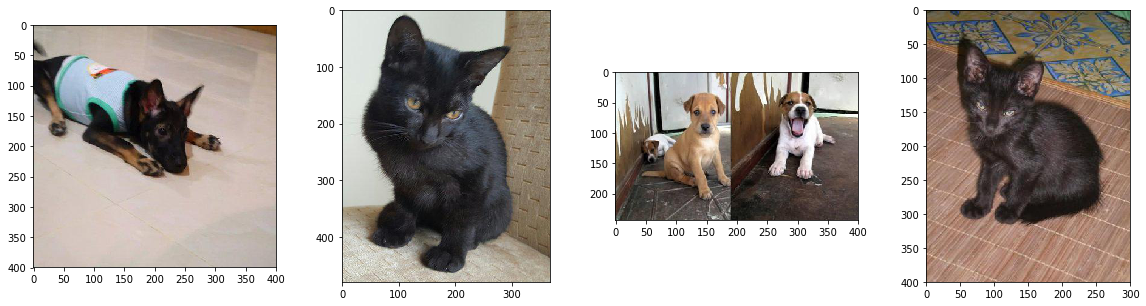

In [118]:
np.random.seed(1515)

inds = np.random.randint(0, 50000, [4])
img_paths = [train_imgs_filepaths[i] for i in inds]
metadatas = [metadata_list[i] for i in inds]

# show imgs
imgs = map(Image.open, img_paths)
f, ax = plt.subplots(1, 4, figsize=(20, 5))
for axx, img in zip(ax.ravel(), imgs):
    axx.imshow(img)
    print(img.width, img.height)
    
crop_hints = [metadata['cropHintsAnnotation'] for metadata in metadatas]
crop_hints

In [121]:
# Assert that there is only one boundingPoly in each cropHitsAnnotation
assert np.product([len(metadata['cropHintsAnnotation']['cropHints']) == 1 for metadata in metadata_list]) == 1
assert np.product([len(metadata['cropHintsAnnotation']['cropHints']) == 1 for metadata in test_metadata_list]) == 1

In [132]:
# Assert that bounding_poly is just the whole image
# If its not, print the example
# WARNING: quiet much logging text
def poly_is_whole_img(bounding_poly, img):
    try:
        if 'vertices' in bounding_poly:
            vertices = bounding_poly['vertices']
    #         4 points for 4 corners
            assert len(vertices) == 4
            assert { 'x': 0, 'y': 0 } in vertices
            assert { 'x': img.width - 1, 'y': 0 } in vertices
            assert { 'x': 0, 'y': img.height - 1 } in vertices
            assert { 'x': img.width - 1, 'y': img.height - 1 } in vertices
        if 'normalizedVertices' in bounding_poly:
            vertices = bounding_poly['normalizedVertices']
            assert len(vertices) == 4
            assert { 'x': 0, 'y': 0 } in vertices
            assert { 'x': 1, 'y': 0 } in vertices
            assert { 'x': 0, 'y': 1 } in vertices
            assert { 'x': 1, 'y': 1 } in vertices
        return True
    except AssertionError:
        return False
        
inc_inds = []
for i, metadata, img_path in zip(range(len(metadata_list)), metadata_list, train_imgs_filepaths):
    img = Image.open(img_path)
    if not poly_is_whole_img(metadata['cropHintsAnnotation']['cropHints'][0]['boundingPoly'], img):
        inc_inds.append(i)
    if i % 1000 == 0:
        print(i)
inc_inds, len(inc_inds)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000


([71,
  192,
  282,
  320,
  366,
  396,
  399,
  427,
  429,
  520,
  556,
  560,
  570,
  688,
  703,
  737,
  801,
  803,
  811,
  813,
  831,
  842,
  843,
  877,
  899,
  922,
  970,
  974,
  1035,
  1040,
  1062,
  1094,
  1165,
  1170,
  1183,
  1234,
  1248,
  1249,
  1267,
  1273,
  1274,
  1291,
  1308,
  1341,
  1385,
  1389,
  1399,
  1403,
  1459,
  1460,
  1468,
  1480,
  1546,
  1632,
  1665,
  1681,
  1694,
  1704,
  1708,
  1720,
  1751,
  1755,
  1756,
  1781,
  1809,
  1862,
  2004,
  2013,
  2041,
  2081,
  2126,
  2133,
  2147,
  2224,
  2226,
  2293,
  2316,
  2339,
  2340,
  2390,
  2440,
  2478,
  2480,
  2513,
  2517,
  2529,
  2581,
  2701,
  2747,
  2751,
  2851,
  2867,
  2869,
  2919,
  2924,
  2926,
  2941,
  2943,
  3011,
  3018,
  3068,
  3121,
  3152,
  3153,
  3154,
  3180,
  3185,
  3187,
  3188,
  3189,
  3196,
  3270,
  3394,
  3398,
  3413,
  3430,
  3446,
  3472,
  3477,
  3478,
  3480,
  3516,
  3559,
  3601,
  3602,
  3623,
  3630,
  3631,
  367